# Convolutional Neural Networks 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Organizing the data into __Train/Validation/Test__ sets:

In [4]:
%pwd

'C:\\Users\\deniz\\OneDrive\\Documents\\Keras'

In [6]:
# Organize data into train, valid, test dirs
os.chdir('dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

In [18]:
# storing paths into variables
train_path = 'C:/Users/deniz/OneDrive/Documents/Keras/dogs-vs-cats/train'
valid_path = 'C:/Users/deniz/OneDrive/Documents/Keras/dogs-vs-cats/valid'
test_path = 'C:/Users/deniz/OneDrive/Documents/Keras/dogs-vs-cats/test'

In [19]:
# put the images into tha Keras generator format. Create bathces of data from the directories 

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [20]:
#Grap 10 images along with the 10 corresponding labels
imgs, labels = next(train_batches)

In [21]:
'''This function will plot images in the form of a grid with 1 row and 10 columns'''
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

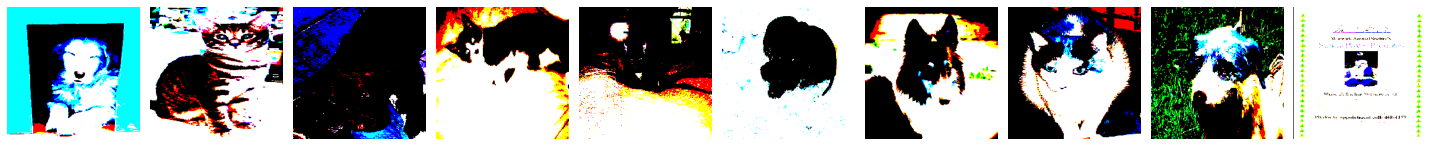

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [22]:
plotImages(imgs)
print(labels)

This is what a batch of training data looks like. We receive warnings that the RGB data is skewed and we can definitely see it as well. Color is most likely distored due to the preprocessing function. <br>
On the one-hot encoded vector below 1.0 represents a cat and a 0.1 represents a dog. 

To build the CNN, we'll use a Keras Sequential model

In [23]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

We compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model 

In [26]:
#if you don't have GPU this is the time to go fetch coffee
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 17s - loss: 14.3087 - accuracy: 0.5490 - val_loss: 4.6252 - val_accuracy: 0.6600
Epoch 2/10
100/100 - 16s - loss: 1.9169 - accuracy: 0.7700 - val_loss: 3.3455 - val_accuracy: 0.6250
Epoch 3/10
100/100 - 16s - loss: 0.4342 - accuracy: 0.9070 - val_loss: 2.4466 - val_accuracy: 0.6450
Epoch 4/10
100/100 - 16s - loss: 0.0952 - accuracy: 0.9730 - val_loss: 2.6568 - val_accuracy: 0.6250
Epoch 5/10
100/100 - 16s - loss: 0.0161 - accuracy: 0.9950 - val_loss: 2.6814 - val_accuracy: 0.6300
Epoch 6/10
100/100 - 16s - loss: 0.0040 - accuracy: 0.9990 - val_loss: 2.6044 - val_accuracy: 0.6100
Epoch 7/10
100/100 - 16s - loss: 9.2287e-04 - accuracy: 1.0000 - val_loss: 2.5994 - val_accuracy: 0.6150
Epoch 8/10
100/100 - 16s - loss: 6.0148e-04 - accuracy: 1.0000 - val_loss: 2.6082 - val_accuracy: 0.6050
Epoch 9/10
100/100 - 16s - loss: 4.8436e-04 - accuracy: 1.0000 - val_loss: 2.6112 - val_accuracy: 0.6100
Epoch 10/10
100/100 - 16s - loss: 4.0123e-04 - accuracy: 1.0000 - val_loss: 2.

We need to specify steps_per_epoch to indicate how many batches of samples from our training set should be passed to the model before declaring one epoch complete. Since we have 1000 samples in our training set, and our batch size is 10, then we set steps_per_epoch to be 100, since 100 batches of 10 samples each will encompass our entire training set.

We're able to use len(train_batches) as a more general way to specify this value, as the length of train_batches is equal to 100 since it is made up of 100 batches of 10 samples. Similarly, we specify validation_steps in the same fashion but with using valid_batches.

We're specifying 10 as the number of epochs we'd like to run, and setting the verbose parameter to 2, which just specifies the verbosity of the log output printed to the console during training.

When we run this line of code, we can see the output of the model over 10 epochs.

In [28]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 16s - loss: 3.3706e-04 - accuracy: 1.0000 - val_loss: 2.6132 - val_accuracy: 0.6050
Epoch 2/10
100/100 - 16s - loss: 2.6938e-04 - accuracy: 1.0000 - val_loss: 2.6183 - val_accuracy: 0.6100
Epoch 3/10
100/100 - 17s - loss: 2.1743e-04 - accuracy: 1.0000 - val_loss: 2.6236 - val_accuracy: 0.6200
Epoch 4/10
100/100 - 16s - loss: 1.7635e-04 - accuracy: 1.0000 - val_loss: 2.6283 - val_accuracy: 0.6250
Epoch 5/10
100/100 - 16s - loss: 1.4255e-04 - accuracy: 1.0000 - val_loss: 2.6369 - val_accuracy: 0.6200
Epoch 6/10
100/100 - 16s - loss: 1.1511e-04 - accuracy: 1.0000 - val_loss: 2.6466 - val_accuracy: 0.6250
Epoch 7/10
100/100 - 16s - loss: 9.4295e-05 - accuracy: 1.0000 - val_loss: 2.6546 - val_accuracy: 0.6250
Epoch 8/10
100/100 - 16s - loss: 7.8950e-05 - accuracy: 1.0000 - val_loss: 2.6670 - val_accuracy: 0.6250
Epoch 9/10
100/100 - 16s - loss: 6.6382e-05 - accuracy: 1.0000 - val_loss: 2.6727 - val_accuracy: 0.6250
Epoch 10/10
100/100 - 16s - loss: 5.6513e-05 - accuracy

When the train accuracy reaches 100% we see that the validation accuracy is ~60% which indicates overfitting.

## Predicting 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

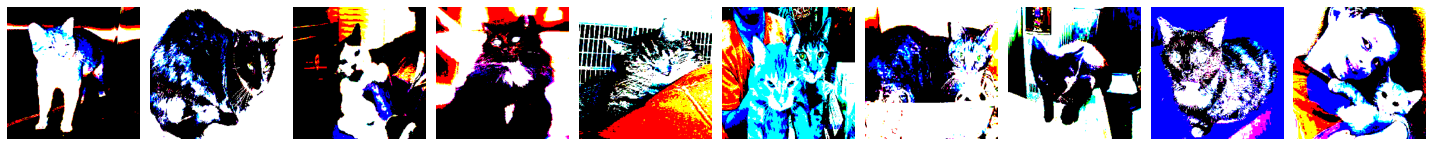

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [30]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [31]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Our 10 first images in our test set is all cats becasue we didn't shuffle. We don't shuffle to keep the correct mapping (in order to build a confusion matrix later on)

In [32]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [33]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

These are the labels that the model is predicting for our images. Here for the 0th element the model predicts the label 0 for example. 

## Visualization with confusion matrix 

In [34]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
#printingout the indices so that we put it correctly on the confusion matrix
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[29 21]
 [18 32]]


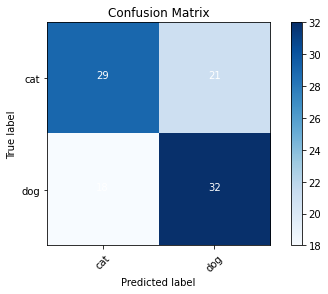

In [37]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

We can see that the model correctly predicted that an image was a cat 29 times when it actually was a cat, and it incorrectly predicted that an image was a cat 18 (I can't read white on white but it is also given above) times when it was not a cat. It correctly predicted that an image was a dog 32 times, and incorrectly predicted that an image was a dog 21 times. <br>

Given what we saw last time from the validation metrics, these results are not surprising.

## Working with the VGG16 preprocessing model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

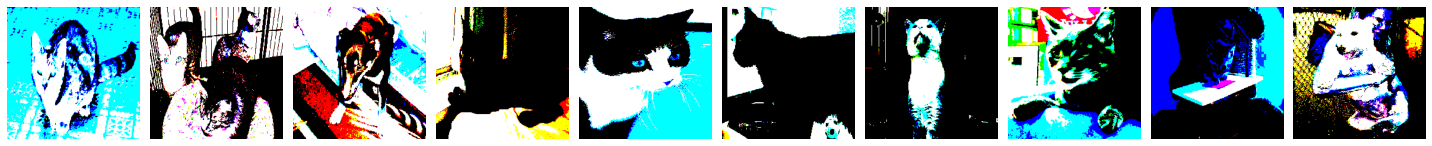

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [38]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [39]:
tf.keras.applications.vgg16.preprocess_input

<function tensorflow.python.keras.applications.vgg16.preprocess_input(x, data_format=None)>

Downloading the model from the internet

In [40]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 72s 0us/step


In [42]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [44]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

We see that this is a "Functional" model. We need to convert it to Sequential.

In [45]:
#Build a new model called Sequential
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

The result is same except the last layer wasn't included. 

In [47]:
#Freezing the weights
for layer in model.layers:
    layer.trainable = False

In [48]:
#Adding our own output class which only has 2 outputs (cat & dog) instead of 1000
model.add(Dense(units=2, activation='softmax'))

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Train the VGG16 model 

In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
#Training the model with the train datase and validate with validation dataset. 
#just 5 epochs because I already have coffee
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Epoch 1/5
100/100 - 74s - loss: 0.3466 - accuracy: 0.8560 - val_loss: 0.0837 - val_accuracy: 0.9650
Epoch 2/5
100/100 - 74s - loss: 0.1012 - accuracy: 0.9660 - val_loss: 0.0495 - val_accuracy: 0.9850
Epoch 3/5
100/100 - 74s - loss: 0.0658 - accuracy: 0.9800 - val_loss: 0.0398 - val_accuracy: 0.9850
Epoch 4/5
100/100 - 75s - loss: 0.0459 - accuracy: 0.9870 - val_loss: 0.0390 - val_accuracy: 0.9850
Epoch 5/5
100/100 - 75s - loss: 0.0347 - accuracy: 0.9930 - val_loss: 0.0343 - val_accuracy: 0.9850


99% accuracy with 98% validation accuracy which is very good. <br> 
VGG18 has already been trained on cats & dog dataset previously so it is normal that it does already 96% right off the bat. 

## Predicting using VGG16 model 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

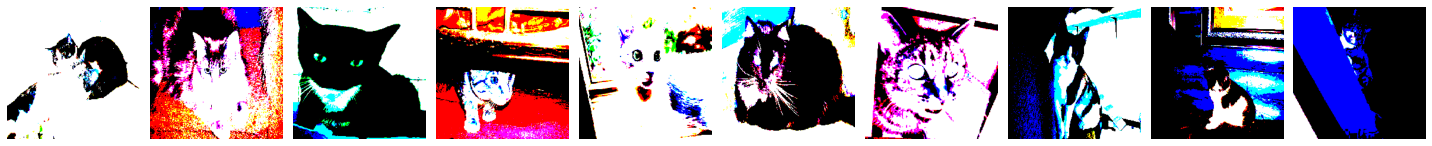

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [52]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

Call model.predict() to have the model predict on the test data.

In [53]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [54]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [55]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [56]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[46  4]
 [ 0 50]]


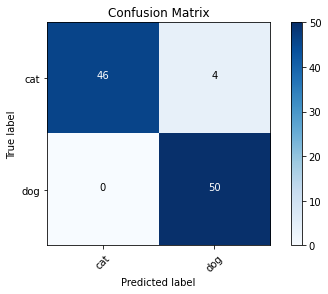

In [57]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')